In [15]:
from src.utils import get_data_zenodo, get_dataset
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

In [2]:
# Data
url = "https://zenodo.org/records/10726643/files/training_set_ref.mat"
filename = "training_set_ref.mat"

df = get_data_zenodo(url, filename, 'training_set')

# Labels
url = "https://zenodo.org/records/10726643/files/class_vector_train_ref.mat"
filename = "class_vector_train_ref.mat"

df_labels = get_data_zenodo(url, filename, 'class_vector_train')

# Parameter names
url = "https://zenodo.org/records/10726643/files/paremeterNames.mat"
filename = "paremeterNames.mat"
 
names = get_data_zenodo(url, filename, 'parameterNames')

# MCC data
url = "https://zenodo.org/records/10726643/files/ccXTR_ref.mat"
filename = "ccXTR_ref.mat"

cc = get_data_zenodo(url, filename, 'commonEnzAct')

# Get dataset
df = get_dataset(data=df, labels=df_labels, names=names)
print(f"Dataset shape: {df.shape}")

Dataset shape: (200000, 259)


**Use a subset of data for computational efficiency**

In [16]:
# Sample N rows for computational efficiency
df = df.sample(5000)
print(df.shape)

(5000, 259)


In [33]:
from src.ppca import generative_ppca

generated_samples_df = generative_ppca(df, 200)
print(generated_samples_df.shape)

KeyboardInterrupt: 

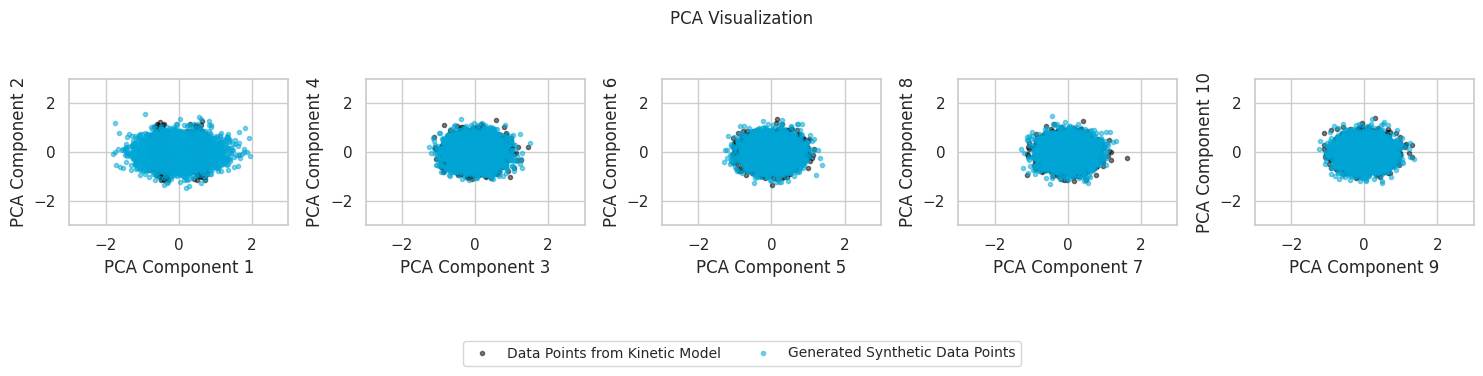

In [31]:
pca_real = PCA(n_components=10, random_state=42)
real_result = pca_real.fit_transform(df.values)
pca_synthetic = PCA(n_components=10, random_state=42)
synthetic_result = pca_synthetic.fit_transform(generated_samples_df.values)

fig, axes = plt.subplots(ncols=5, figsize=(15, 3))
for j, ax in enumerate(axes):
    index = 2 * j
    index2 = index + 1
    ax.plot(real_result[:, index], real_result[:, index2], ".", color="black", label="Data Points from Kinetic Model", alpha=0.5)
    ax.plot(synthetic_result[:, index], synthetic_result[:, index2], ".", color="#00a6d6", label="Generated Synthetic Data Points", alpha=0.5)
    ax.set_xlabel(f"PCA Component {index + 1}")
    ax.set_ylabel(f"PCA Component {index2 + 1}")
    ax.grid(True)  # Add grid lines
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])

fig.legend(['Data Points from Kinetic Model','Generated Synthetic Data Points'], loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=10)
fig.suptitle("PCA Visualization", fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

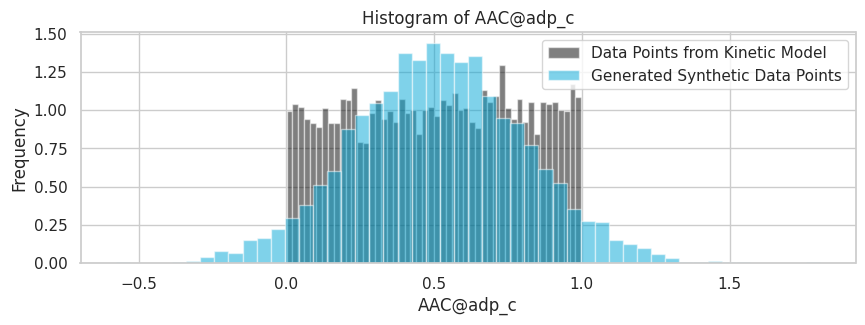

In [32]:
# Plot histogram for a random feature for both real and synthetic data
feature = random.choice(df.columns)
plt.figure(figsize=(10, 3))
plt.hist(df.values[:, df.columns.get_loc(feature)], density=True, bins=50, color="black", alpha=0.5, label="Data Points from Kinetic Model")
plt.hist(generated_samples_df[feature], density=True, bins=50, color="#00a6d6", alpha=0.5, label="Generated Synthetic Data Points")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Histogram of {feature}")
plt.show()


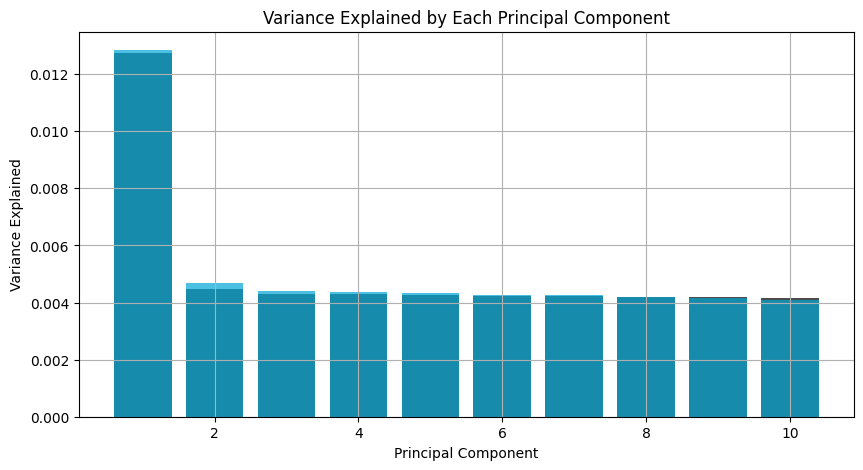

In [6]:
# Calculate the variance explainer by each PCA component and use a bar plot to visualize the results
variance_explained = pca_real.explained_variance_ratio_
variance_explained_synth = pca_synthetic.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.7, color="black")
ax.bar(range(1, len(variance_explained_synth) + 1), variance_explained_synth, alpha=0.7, color="#00a6d6")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained")
ax.set_title("Variance Explained by Each Principal Component")
plt.grid(True)
plt.show()



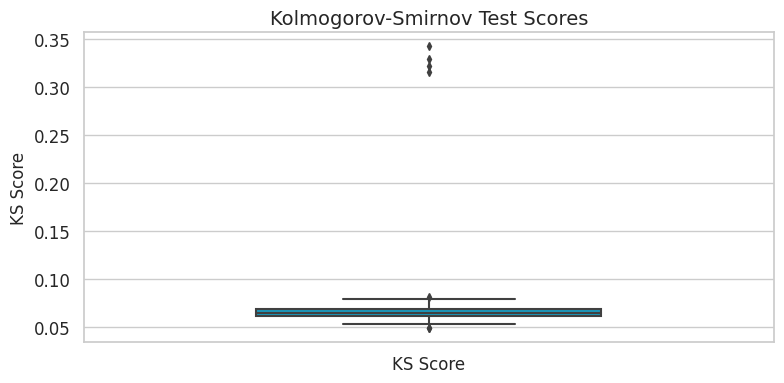

In [22]:
from scipy.stats import ks_2samp, entropy

KS = []
P = []
for c in df.columns:
    ks = ks_2samp(df[c], generated_samples_df[c])
    KS.append(ks.statistic)
    P.append(ks.pvalue)
    # print(f'KS score for {c}: {ks.statistic} with p-value {ks.pvalue}')
    # print("-----------------")
    
  
# Create a dataframe to store the results
results = pd.DataFrame({"Feature": df.columns, "KS": KS, "P": P})
results = results.sort_values("KS", ascending=False)
results = results.reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create a boxplot for KS scores
fig, ax = plt.subplots(figsize=(8, 4))

# Customizing boxplot aesthetics
sns.boxplot(data=results["KS"], orient="v", color="#00a6d6", width=0.5, linewidth=1.5, fliersize=4, ax=ax)

# Customize title and axes labels
ax.set_xticklabels(["KS Score"], fontsize=12)
ax.set_title("Kolmogorov-Smirnov Test Scores", fontsize=14)
ax.set_ylabel("KS Score", fontsize=12)

# Customize tick labels
ax.tick_params(axis="both", labelsize=12)

plt.tight_layout()  # Adjust layout for better spacing

plt.show()


In [8]:
results.sort_values("KS", ascending=False).head(10)

,Feature,KS,P
0,stability,0.35390,0.000000e+00
1,NDR@nadph_c,0.34676,0.000000e+00
2,ATPM@adp_c,0.34380,0.000000e+00
3,NDR@fero_m,0.34056,0.000000e+00
4,ADK@adp_c,0.07804,7.113582e-133
5,ENO@2pg_c,0.07098,5.706138e-110
6,OAt@oaa_m,0.06638,3.213971e-96
7,CO2m@co2_c,0.06602,3.500830e-95
8,PDA@accoa_m,0.06580,1.496874e-94
9,FBA@fbp_c,0.06566,3.763906e-94


In [23]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [25]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)
synthetic_data = synthesizer.sample(2000)

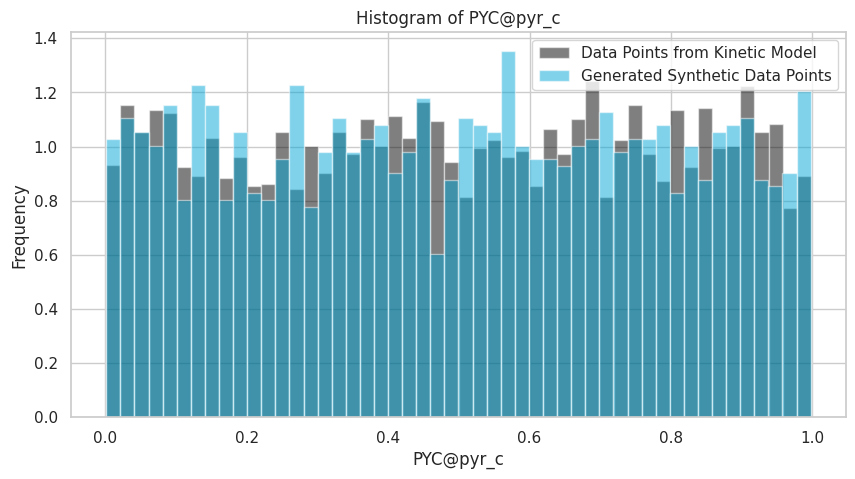

In [28]:
# Plot histogram for a random feature for both real and synthetic data
feature = random.choice(df.columns)
plt.figure(figsize=(10, 5))
plt.hist(df[feature], density=True, bins=50, color="black", alpha=0.5, label="Data Points from Kinetic Model")
plt.hist(synthetic_data[feature], density=True, bins=50, color="#00a6d6", alpha=0.5, label="Generated Synthetic Data Points")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Histogram of {feature}")
plt.show()

In [97]:
import pandas as pd
import h5py

filename = 'kinetic_params_top_10_models.hdf5'

with h5py.File(filename, 'r') as f:
    keys = list(f.keys())
    idxs = list(f[keys[0]])
    names = list(f[keys[2]])
    set_0 = list(f[keys[3]])
    

idxs = [i.decode("utf-8") for i in idxs]
names = [name.decode("utf-8") for name in names]

df = pd.DataFrame(columns=names)
df.loc[0] = set_0
df.loc[1] = set_1


762

,vmax_forward_ACALDtex,k_equilibrium_ACALDtex,acald_e,vmax_forward_ACALDtpp,k_equilibrium_ACALDtpp,km_substrate_ACALDtpp,km_product_ACALDtpp,vmax_forward_ACONTa,k_equilibrium_ACONTa,km_substrate_ACONTa,...,km_product1_TALA,km_substrate2_TALA,km_product2_TALA,ki_inhibitor1_TALA,volume_c,cell_volume_c,volume_e,cell_volume_e,volume_p,cell_volume_p
0,1.278381e+07,25.828989,9.936514,1.367128e+07,7.768868,320.512633,1144.094197,4.337062e+09,0.050602,8.179616e+06,...,4.694990e+06,184371.23531,556595.519997,4.500278e+06,0.9,1.0,1.0,1.0,0.1,1.0


In [33]:
keys

['index',
 'num_parameters_sets',
 'parameter_names',
 'parameter_set_0',
 'parameter_set_1',
 'parameter_set_2',
 'parameter_set_3',
 'parameter_set_4',
 'parameter_set_5',
 'parameter_set_6',
 'parameter_set_7',
 'parameter_set_8',
 'parameter_set_9']